# Portfolio Optimization
In this notebook, we will first solve the problem discussed in [this lecture note](https://www2.isye.gatech.edu/~sahmed/isye6669/notes/portfolio). Then using the same data, we will solve three different optimization problems commonly encountered in Portfolio optimization.

1. Exact problem discussed in the lecture note
2. Maximizing mean return
3. Minimizing risk
4. Simultaneously maximizing mean and minimizing risk

We will use [CVXPY](https://www.cvxpy.org/) library to solve constrained quadratic optimization problems.

Import relevant libraries.

In [1]:
import  cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Problem discussed in the lecture note
The dataset used in this notebook can be found in the lecture notes of [Prof. Shabbir Ahmed](https://www2.isye.gatech.edu/people/faculty/Shabbir_Ahmed/). The lecture note can be found at [this link](https://www2.isye.gatech.edu/~sahmed/isye6669/notes/portfolio).

Read the data.

In [2]:
IBM = np.array([93.043, 84.585, 111.453, 99.525, 95.819, 114.708, 111.515, 113.211, 104.942, 99.827, 91.607, 107.937, 115.590])
WMT = np.array([51.826, 52.823, 56.477, 49.805, 50.287, 51.521, 51.531, 48.664, 55.744, 47.916, 49.438, 51.336, 55.081])
SEHI = np.array([1.063, 0.938, 1.000, 0.938, 1.438, 1.700, 2.540, 2.390, 3.120, 2.980, 1.900, 1.750, 1.800])

data = pd.DataFrame(data = {"IBM":IBM, "WMT":WMT, "SEHI":SEHI})
data

,IBM,WMT,SEHI
0,93.043,51.826,1.063
1,84.585,52.823,0.938
2,111.453,56.477,1.000
3,99.525,49.805,0.938
4,95.819,50.287,1.438
5,114.708,51.521,1.700
6,111.515,51.531,2.540
7,113.211,48.664,2.390
8,104.942,55.744,3.120
9,99.827,47.916,2.980


In [3]:
data.shape

(13, 3)

### Calculate change in stock price
Change in stock price is calculated by subtracting a given day's stock price from following day's stock price.

In [4]:
change_in_stock_price = data.diff()
change_in_stock_price = change_in_stock_price.iloc[1:,:]
change_in_stock_price

,IBM,WMT,SEHI
1,-8.458,0.997,-0.125
2,26.868,3.654,0.062
3,-11.928,-6.672,-0.062
4,-3.706,0.482,0.500
5,18.889,1.234,0.262
6,-3.193,0.010,0.840
7,1.696,-2.867,-0.150
8,-8.269,7.080,0.730
9,-5.115,-7.828,-0.140
10,-8.220,1.522,-1.080


### Calculate rate of change of stock price

In [5]:
rate_of_return = change_in_stock_price / data.iloc[:-1,:].values
rate_of_return

,IBM,WMT,SEHI
1,-0.090904,0.019237,-0.117592
2,0.317645,0.069174,0.066098
3,-0.107023,-0.118137,-0.062000
4,-0.037237,0.009678,0.533049
5,0.197132,0.024539,0.182197
6,-0.027836,0.000194,0.494118
7,0.015209,-0.055636,-0.059055
8,-0.073041,0.145487,0.305439
9,-0.048741,-0.140428,-0.044872
10,-0.082342,0.031764,-0.362416


### Sample covariance matrix

In [6]:
C = rate_of_return.cov()
C

,IBM,WMT,SEHI
IBM,0.018641,0.003599,0.001310
WMT,0.003599,0.006437,0.004887
SEHI,0.001310,0.004887,0.068683


Covariance matrix given in the paper is slightly different from this result.

### Mean return for each stock

In [7]:
means = rate_of_return.mean(axis = 0).values
means

array([0.02600215, 0.00810132, 0.07371591])

### Optimization problem of the book

Notation:
C: Covariance matrix


Problem: 
$$\min x^TCx$$
s.t.
$$e^Tx \leq 1000$$
$$\bar{r}^Tx \geq 50$$
$$ x \geq 0$$

The solver solves problems of the following kind:
$$ \min x^TCx + q^T x$$
s.t.
$$Gx \leq h$$
$$Ax = b$$

So we convert our constraints to a form understandable by the solver. We don't have any equality constraints. We modify all inequality constraints to less than equal to type. The matrix $G$ takes following form.
$$\begin{pmatrix}
1 & 1 & 1\\
-0.026 & -0.008 & -0.073\\
-1 & 0 & 0\\
0 & -1 & 0\\
0 & 0 & -1\\
\end{pmatrix} \begin{pmatrix} x_1 \\ 
x_2 \\
x_3 \end{pmatrix}\leq 
\begin{pmatrix}
1000\\ 
-50 \\ 
0\\ 
0 \\ 
0 \end{pmatrix}$$

In [8]:
G = np.concatenate((np.array([[1, 1, 1],-means]), -np.eye(3)), axis = 0)
G

array([[ 1.        ,  1.        ,  1.        ],
       [-0.02600215, -0.00810132, -0.07371591],
       [-1.        , -0.        , -0.        ],
       [-0.        , -1.        , -0.        ],
       [-0.        , -0.        , -1.        ]])

In [9]:
h = np.array([1000, -50, 0, 0, 0])
h = np.resize(h, (5,))
h

array([1000,  -50,    0,    0,    0])

In [10]:
n = 3
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(cp.quad_form(x,C.values)),   # Objective
                  [G@x <= h])                              # Constraints
prob.solve()
print("Variance is: ", prob.value)
print("Solution (x) is : ", x.value)

Variance is:  22634.41845654453
Solution (x) is :  [4.97045504e+02 3.12277098e-21 5.02954496e+02]


Obtained variance is higher than that of the paper. This is because the covariance matrix given in the paper is slightly different that sample covariance matrix.

## 2. Maximizing mean return

$m$ : mean 

$ e= [1, 1, 1]^T$

Problem:
$$\max x^Tm$$
s.t.
$$e^Tx = 1$$
$$x^TCx \leq \sigma_0^2$$
$$ x \geq 0$$

We have taken $\sigma_0^2 = 130$.

In [11]:
e = np.ones(shape = (1,3))
n = 3
x_2 = cp.Variable(n)
prob_2 = cp.Problem(cp.Maximize(x_2.T @ means),
                      [e @ x_2 == 1,                            # First constraint
                       cp.quad_form(x_2,C.values) <= 130,       # Second constraint
                       -np.eye(3) @ x_2 <= np.array([0,0,0])])  # Third constraint
prob_2.solve()
print("Mean return is: ", prob_2.value)
print("Solution (x) is: ", x_2.value)

Mean return is:  0.073715909403193
Solution (x) is:  [5.04533114e-10 9.86392904e-10 9.99999999e-01]


## 3. Minimizing risk
$e = [1, 1, 1]^T$

$m$ = mean 

Problem:
$$ \min x^TCx$$
s.t.
$$e^Tx = 1$$
$$x^Tm = m_0$$
$$ x \geq 0 $$

We have taken $m_0 = 0.05$. We have taken this peculiar value because solution doesn't exist for all values of $m_0$. For $m_0 = 1, 5, 10, 50, etc. $ no solution exists.

In [12]:
m_0 = 0.05
n = 3
x_3 = cp.Variable(n)
prob_3 = cp.Problem(cp.Minimize(cp.quad_form(x_3, C.values)),
                    [np.ones(shape = (1,3)) @ x_3 == 1,                # First constraint
                     np.reshape(means, newshape = (1,3)) @ x_3 == m_0, # Second constraint
                     -np.eye(3) @ x_3 <= np.array([0,0,0])])           # Third constraint
prob_3.solve()
print("Minimum variance is: ", prob_3.value)
print("Solution (x) is: ", x_3.value)

Minimum variance is:  0.02263441845654455
Solution (x) is:  [ 4.97045504e-01 -1.68881985e-23  5.02954496e-01]


## 4. Simultaneously maximizing mean return and minimizing risk
We have taken $\lambda = 5$. $\lambda$ value can  be changed to control risk and obtain different results.

$e = [1, 1, 1]^T$


Problem:
$$\max x^Tm - \lambda x^TCx$$
s.t.
$$e^Tx = 1$$
$$ x \geq 0$$

In [13]:
e = np.ones(shape = (1,3))
n = 3
lamda = 5.0
x_4 = cp.Variable(n)
prob_4 = cp.Problem(cp.Maximize(x_4.T @ means - lamda*cp.quad_form(x_4, C.values)),
                    [ e @ x_4 == 1,                            # First constraint
                     -np.eye(3) @ x_4 <= np.array([0,0,0])])   # Second constraint
prob_4.solve()
print("Maximum value is: ", prob_4.value)
print("Solution (x) is: ", x_4.value)

Maximum value is:  -0.012816117651260707
Solution (x) is:  [0.26410505 0.60878024 0.12711471]


### Solving for different values of $\lambda$ 

In [14]:
e = np.ones(shape = (1,3))
n = 3
lamda = np.logspace(start = -3, stop = 3, num = 50)
values = []
x_values = []
for lam in lamda:
    x_new = cp.Variable(n)
    prob_new = cp.Problem(cp.Maximize(x_new.T @ means - lam*cp.quad_form(x_new, C.values)),
                        [ e @ x_new == 1,                            # First constraint
                         -np.eye(3) @ x_new <= np.array([0,0,0])])   # Second constraint
    prob_new.solve()
    values.append(prob_new.value)
    x_values.append(x_new.value)

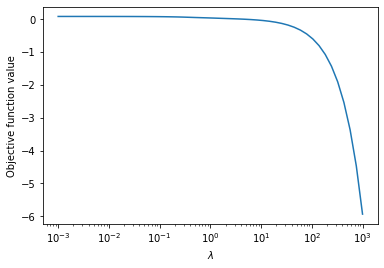

In [15]:
# Plot the result
plt.semilogx(lamda, values)
plt.xlabel("$\lambda$")
plt.ylabel("Objective function value")
plt.savefig("objective_fun_value.png")
plt.show()

In [16]:
fraction_of_investment = np.array(x_values)
fraction_of_investment.shape

(50, 3)

In [17]:
mean_returns = fraction_of_investment@means
mean_returns

array([0.07371591, 0.07371591, 0.07371591, 0.07371591, 0.07371591,
       0.07371591, 0.07371591, 0.07371591, 0.07371591, 0.07371591,
       0.07371591, 0.07371591, 0.07371591, 0.07371591, 0.07371591,
       0.07371591, 0.07371591, 0.07371591, 0.07371591, 0.07371591,
       0.07371591, 0.07181632, 0.0629589 , 0.05627765, 0.05123789,
       0.04743635, 0.04058805, 0.03372067, 0.02854053, 0.02463308,
       0.02168564, 0.01946236, 0.01778531, 0.01652029, 0.01556607,
       0.01484629, 0.01430335, 0.01389381, 0.01358488, 0.01335186,
       0.01317608, 0.0130435 , 0.01294348, 0.01286804, 0.01281114,
       0.01276821, 0.01273583, 0.01271141, 0.01269299, 0.01267909])

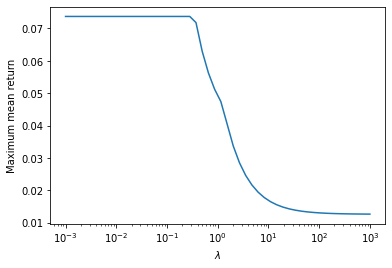

In [18]:
plt.semilogx(lamda, mean_returns)
plt.xlabel("$\lambda$")
plt.ylabel("Maximum mean return")
plt.savefig("maximum_mean_return_wrt_lambda.png")
plt.show()

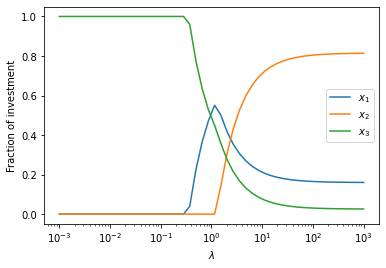

In [19]:
plt.semilogx(lamda, fraction_of_investment[:,0], label = "$x_1$")
plt.semilogx(lamda, fraction_of_investment[:,1], label = "$x_2$")
plt.semilogx(lamda, fraction_of_investment[:,2], label = "$x_3$")
plt.legend()
plt.xlabel("$\lambda$")
plt.ylabel("Fraction of investment")
plt.savefig("fraction_of_investment.png")
plt.show()